# Short-Term Forecast Models:

In [214]:
import numpy as np
import pandas as pd
import yfinance as yf
import fredapi as fa


#ML
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
import hvplot.pandas
import xgboost as xgb


from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import tree
from sklearn.tree import export_graphviz

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

<br>

1. Function for manipulating pct_changes:

In [157]:
def percent_ch(df, how_far_away, divided_by):
    x = ( df.shift(how_far_away) / df.shift(divided_by) ) -1
    
    return x

2) Function for correlation and R2:

In [158]:
def calculate_correlation(df, col1, col2):
    """
    Calculate the correlation coefficient and R2 score between two columns in a DataFrame.
    
    Args:
        df (pandas.DataFrame): The DataFrame containing the columns.
        col1 (str): The name of the first column.
        col2 (str): The name of the second column.
    
    Returns:
        tuple: A tuple containing the correlation coefficient and R2 score.
    """
    # calculate the correlation coefficient between the two columns
    covariance = ((df[col1] - df[col1].mean()) * (df[col2] - df[col2].mean())).sum() / (df.shape[0] - 1)
    std_x = df[col1].std(ddof=1)
    std_y = df[col2].std(ddof=1)
    correlation = covariance / (std_x * std_y)

    # calculate the R2 score
    r2 = correlation**2

    # return the correlation coefficient and R2 score as a tuple
    return correlation, r2

3) Function for Winsorizing:

In [159]:
def winsorize_(data, limits):
    lower_limit = np.percentile(data, limits[0])
    upper_limit = np.percentile(data, 100 - limits[1])
    data[data < lower_limit] = lower_limit
    data[data > upper_limit] = upper_limit
    return data

<br>

## Data Cleaning:

In [231]:
#FRED DATA
fred = fa.Fred(api_key='467827ab5d3d05c7881f60e1fd180ed8')

In [234]:
#IMPORT SP DATA
sp = pd.read_csv("S&P.csv", index_col = 0, parse_dates=True, infer_datetime_format=True)

# CLEAN SOME DATA
new_df = sp.drop(columns=['Index'])
newer_df = new_df.reset_index()
newer_df1 = newer_df.drop(columns=['index'])

#Further cleaning
sp_df = newer_df1.set_index('yyyymm')
sp_df = sp_df.rename(columns = {'Index.1': 'Index'})

# Change the index to a better format (datewise)
sp_df.index = pd.to_datetime(sp_df.index.astype(str), format='%Y%m')

In [237]:
sp_df.head() #Dates look good now

,Index,D12
yyyymm,,
1871-01-01,4.44,0.26
1871-02-01,4.50,0.26
1871-03-01,4.61,0.26
1871-04-01,4.74,0.26
1871-05-01,4.86,0.26


**RUN TO GET ALL FACTORS RAW:**

In [164]:
def establish_factors(sp_df):
    
    
    sp_df['1M_ret'] = sp_df['Index'].pct_change()

    sp_df['2M_ret'] = sp_df['Index'].pct_change(periods = 2)
    
    sp_df['Raw_12_MOM'] = sp_df['Index'].pct_change(periods = 12)
    
    sp_df['Raw_9_MOM'] = sp_df['Index'].pct_change(periods = 9)
    
    sp_df['D/P'] = (sp_df['D12'] / sp_df['Index']) 
    
    
# Establish Clean dataframe:
    
    cleaned_data = pd.DataFrame(index = sp_df.index)
    
    #12_M forward
    cleaned_data['12M_forward'] = np.log(sp_df['Index'].shift(-12) / sp_df['Index'] )
    
    #12m MOM
    cleaned_data['12M_Mom'] = sp_df['Raw_12_MOM']
    
    #9m MOM
    cleaned_data['9M_Mom'] = sp_df['Raw_9_MOM']
    
    #12 - 1
    #cleaned_data['12minus1'] = sp_df['Raw_12_MOM'] - sp_df['1M_ret']
    
    #12 - 2
    #cleaned_data['12minus2'] = sp_df['Raw_12_MOM'] - sp_df['2M_ret']
    
    #Dividend / Price (Div Yield)
    cleaned_data['%_ch_D/P'] = sp_df['D/P'].pct_change(periods = 1)  # CHANGING TO 6 ADDS MORE R-2 but it PERHAPS CORRELATED TO MOMENTUM
    
    # Valuation
    cleaned_data['5Y_val'] = sp_df['Index'].pct_change(periods = 60)
    

    
    return cleaned_data

Establish Cleaner dataset:

In [248]:
clean_data = establish_factors(sp_df)
clean = clean_data.dropna(axis=0)
clean = clean.loc['1937-05-01':]
clean

,12M_forward,12M_Mom,9M_Mom,%_ch_D/P,5Y_val
yyyymm,,,,,
1937-05-01,-0.561925,0.129167,0.016886,0.049319,2.637584
1937-06-01,-0.286817,0.037736,-0.038101,0.094949,2.476298
1937-07-01,-0.314340,0.071293,-0.013364,-0.118208,1.783607
1937-08-01,-0.285191,0.003127,-0.071759,0.028272,0.911800
1937-09-01,-0.117057,-0.140537,-0.199069,0.131460,0.702970
...,...,...,...,...,...
2020-08-01,0.256253,0.196090,0.114401,-0.069841,0.774843
2020-09-01,0.247534,0.129759,0.040925,0.035947,0.751535
2020-10-01,0.342447,0.076509,0.013778,0.025119,0.572580


Establish risk-free rate:

In [251]:
#IMPORT RF_RATE data
rf_rate = pd.read_csv("data.csv", index_col = 0, parse_dates=True, infer_datetime_format=True)
rf_rate = rf_rate['Rfree']
rf_rate.index = clean.index
rf_rate.head()

yyyymm
1937-05-01    0.0006
1937-06-01    0.0003
1937-07-01    0.0003
1937-08-01    0.0002
1937-09-01    0.0004
Name: Rfree, dtype: float64

### *Cleaning the Explanatory Variables further:*

In [252]:
explan_variables = clean.copy()
explan_variables = explan_variables.drop('12M_forward', axis=1)

Winsorize:

In [253]:
# clean_X = winsorize_(explan_variables, (0.1, 0.1))
# clean_X.plot()

Z-score:

In [254]:
# super_clean_X = StandardScaler().fit_transform(winsorized_x)
# clean_X = pd.DataFrame(super_clean_X, index = winsorized_x.index, columns = winsorized_x.columns)
# clean_X.plot()

## Modelling:

In [255]:
explan_variables.columns #Select the Factors you want

Index(['12M_Mom', '9M_Mom', '%_ch_D/P', '5Y_val'], dtype='object')

<br>

#### *Split data into training and testing datasets for OOS:*

In [260]:
# Set Model

y = clean['12M_forward'] - rf_rate

X = explan_variables[['5Y_val', '12M_Mom']] # Change this to change X_variables ['5Y_val', '9M_Mom', '%_ch_D/P']




train_proportion = 0.7 # Train dataset proportion

split_index = int(len(X) * train_proportion) # Simply splitting the whole (972) length of the X variable into 70% for the training data-set

# Split the data into training and testing sets based on the split index
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

<br>

<span style="color:blue">Linear Regression:</span>

In [261]:
model = LinearRegression().fit(X_train, y_train)
print(f'In-Sample Coefficients: {model.coef_},         In-Sample Intercept: {model.intercept_:.5f},            In-Sample R-squared: {model.score(X_train, y_train):.7f}')

In-Sample Coefficients: [-0.02237109 -0.11206546],         In-Sample Intercept: 0.08237,            In-Sample R-squared: 0.0250601


<br>

In [262]:
#Predict Values OOS with in-sample coefficients
linear_prediction = model.predict(X_test)

#Collate to DataFrame
OOS = pd.DataFrame(linear_prediction, index = y_test.index, columns = ['prediction'])

# Add The 12M Return
OOS['actual'] = y_test

OOS.hvplot(kind="scatter", x = 'prediction', y='actual')

:Scatter   [prediction]   (actual)

In [263]:
oos_r2 = calculate_correlation(OOS, 'actual', 'prediction')
oos_mse = mean_squared_error(OOS['actual'], OOS['prediction'])

print(f' Out of Sample Corr, R^2 and MSE = {oos_r2, round(oos_mse, 6)}')

 Out of Sample Corr, R^2 and MSE = ((-0.031057450147423667, 0.0009645652096597064), 0.030228)


<br>

<span style="color:blue">Ridge:</span>

In [264]:
model3 = Ridge(alpha = 0.3).fit(X_train, y_train)
print(f'In-Sample Coefficients: {model3.coef_},         In-Sample Intercept: {model3.intercept_:.5f},            In-Sample R-squared: {model3.score(X_train, y_train):.7f}')

In-Sample Coefficients: [-0.02266208 -0.11000423],         In-Sample Intercept: 0.08235,            In-Sample R-squared: 0.0250559


In [265]:
#Predict Values OOS with in-sample coefficients
ridge_pred = model3.predict(X_test)

#Collate to DataFrame
OOS1 = pd.DataFrame(ridge_pred, index = y_test.index, columns = ['prediction'])

# Add The 12M Return
OOS1['actual'] = y_test
OOS1.hvplot(kind="scatter", x = 'prediction', y='actual')

:Scatter   [prediction]   (actual)

In [266]:
oos_r2_ = calculate_correlation(OOS1, 'actual', 'prediction')
oos_mse1 = mean_squared_error(OOS1['actual'], OOS1['prediction'])

print(f' Out of Sample Corr, R^2 and MSE = {oos_r2_, round(oos_mse1, 6)}')

 Out of Sample Corr, R^2 and MSE = ((-0.027837012059967785, 0.000774899240426792), 0.030189)


<br>

<span style="color:blue">Decision Tree:</span>

In [267]:
from sklearn.tree import plot_tree

In [268]:
tree1 = tree.DecisionTreeRegressor(min_samples_split = 50).fit(X_train, y_train)
y_pred = tree1.predict(X_test)

In [269]:
mse_DT = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse_DT)

Mean Squared Error: 0.038792317330728285


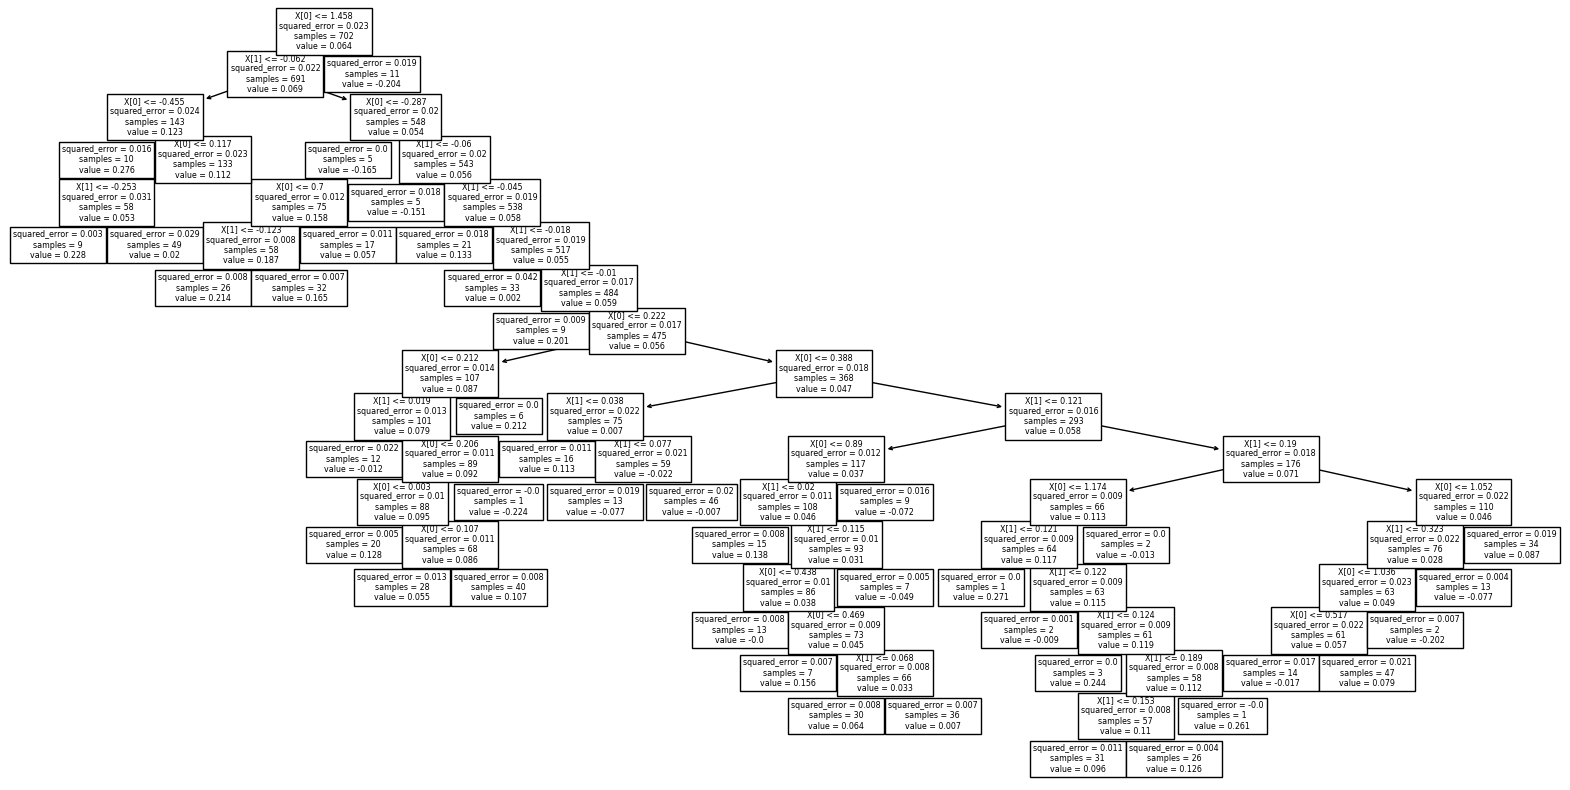

In [270]:
plt.figure(figsize=(20,10))
plot_tree(tree1)
plt.show()

<br>

<span style="color:blue">Gradient Boost:</span>

In [271]:
# create gradient boosting regression model
gb_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=10, min_samples_split = 50).fit(X_train, y_train)
y_pred1 = gb_model.predict(X_test)

In [272]:
mse_GB = mean_squared_error(y_test, y_pred1)
print('Mean Squared Error:', mse_GB)

Mean Squared Error: 0.03774208103224582


In [273]:
#Collate to DataFrame
OOS2 = pd.DataFrame(y_pred1, index = y_test.index, columns = ['prediction'])

# Add The 12M Return
OOS2['actual'] = y_test
OOS2.hvplot(kind="scatter", x = 'prediction', y='actual')

:Scatter   [prediction]   (actual)

In [274]:
oos_r2_grad_boost = calculate_correlation(OOS2, 'actual', 'prediction')
oos_r2_grad_boost

(0.13994831282647338, 0.019585530262976453)

<br>

<span style="color:blue">XGBoost:</span>

In [275]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=10, min_samples_split = 50).fit(X_train, y_train)

preds = xg_reg.predict(X_test)

[13:46:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [276]:
#Collate to DataFrame
OOS5 = pd.DataFrame(preds, index = y_test.index, columns = ['prediction'])

# Add The 12M Return
OOS5['actual'] = y_test

oos_r2_xgboost = calculate_correlation(OOS5, 'actual', 'prediction')
oos_r2_xgboost

(0.06982497379768694, 0.004875526965847668)

In [277]:
mse2 = mean_squared_error(y_test, preds)
print('Mean Squared Error:', mse2)

Mean Squared Error: 0.03817497199497399


In [278]:
results = pd.DataFrame({'xg_boost':preds, 'dec_tree': y_pred, 'grad_boost': y_pred1, 'Ridge': ridge_pred, 'OLS': linear_prediction, 'actual':y_test}, index = y_test.index)
results['split_OLS_grad_boost'] = (results['grad_boost'] + results['OLS'] ) / 2
results.head()

,xg_boost,dec_tree,grad_boost,Ridge,OLS,actual,split_OLS_grad_boost
yyyymm,,,,,,,
1995-11-01,-0.089997,-0.076932,-0.032783,0.025654,0.025246,0.219350,-0.003769
1995-12-01,-0.032492,-0.076932,0.077829,0.025215,0.024789,0.179616,0.051309
1996-01-01,-0.093226,-0.076932,-0.040422,0.024375,0.023922,0.207630,-0.008250
1996-02-01,0.173557,0.079441,0.114162,0.030928,0.030523,0.207031,0.072342
1996-03-01,0.041209,0.079441,0.158144,0.034212,0.033851,0.155597,0.095997


In [279]:
results.hvplot(kind="scatter", y='actual', x='grad_boost')

:Scatter   [grad_boost]   (actual)

In [280]:
o_o_s = pd.DataFrame({'OOS_R2': [oos_r2[1], oos_r2_[1], oos_r2_grad_boost[1], oos_r2_xgboost[1], 'NA'], 'OOS_MSE': [oos_mse, oos_mse1, mse_GB, mse2, mse_DT]}, index = ['OLS', 'RIDGE', 'GRAD_BOOST', 'XGBOOST', 'DECISION_TREE'])
o_o_s = o_o_s*100

o_o_s.iloc[4,0] = 'NA'


o_o_s

,OOS_R2,OOS_MSE
OLS,0.096457,3.022837
RIDGE,0.07749,3.018866
GRAD_BOOST,1.958553,3.774208
XGBOOST,0.487553,3.817497
DECISION_TREE,NA,3.879232


In [281]:
final1 = calculate_correlation(results, 'actual','OLS')
final1

(-0.031057450147423667, 0.0009645652096597064)

In [195]:
final2 = calculate_correlation(results, 'actual','split_OLS_grad_boost')
final2

(0.14584781254251827, 0.021271584423437552)

In [196]:
final3 = calculate_correlation(results, 'actual','grad_boost')
final3

(0.14727239742931747, 0.021689159044578833)

<br>

# Shrink Across other equity_country_indices

### Clean data into proper length's and define:

In [364]:
dataframe = pd.read_csv('equity_country_indices.csv', index_col = 0)

data_dict = {
    'y_dict' : {},
    'val_dict' : {},
    'mom_dict' : {}
}

for i in dataframe.columns:
    
    data_dict['y_dict'][i] = (np.log(dataframe[i].shift(-12) / dataframe[i])) #12_M forward

    data_dict['val_dict'][i] = (dataframe[i].pct_change(periods = 60)) # VAL

    data_dict['mom_dict'][i] = (dataframe[i].pct_change(periods = 12)) # MOM

# Set as DF's
y_df = pd.DataFrame(data_dict['y_dict']).dropna(axis=0)
val_df = pd.DataFrame(data_dict['val_dict']).dropna(axis=0)
mom_df = pd.DataFrame(data_dict['mom_dict']).dropna(axis=0)

# Align Dates (full sample)
mom_df = mom_df.loc['1/01/1965':'1/12/2020']
y_df = y_df.loc['1/01/1965':]
val_df = val_df.loc[:'1/12/2020']

In [369]:
# SET THE INSAMPLE PERIOD THROUGH THE LOC:
insample_y, insample_val, insample_mom = [df.loc['1/01/1965':'1/12/2003'] for df in [y_df, val_df, mom_df]]

### Closed_Form_OLS Function:

In [370]:
def closed_form_OLS(y_df, x1_df, x2_df):
    reg_results = pd.DataFrame(columns=['country', 'intercept', 'Valuation_beta', 'Momentum_beta'])

    # perform the regression by looping over each country
    for country in y_df.columns:

        #Slicing data for current country
        y = y_df[country]
        x1 = x1_df[country]
        x2 = x2_df[country]

        #Create a design Matrix X & insert '1s' in a column:
        X_matrix = np.column_stack((np.ones(len(x1)), x1, x2)) # inserting the looped country values 

        #Caclulate the regression coefficients through the closed form solution:
        beta_hat = np.linalg.inv(X_matrix.T @ X_matrix) @ X_matrix.T @ y


        # append the results to the output dataframe
        reg_results = reg_results.append({
            'country': country,
            'intercept': beta_hat[0],
            'Valuation_beta': beta_hat[1],
            'Momentum_beta': beta_hat[2]
        }, ignore_index=True)

    return reg_results

Using the function on our in-sample-data:

In [371]:
output_insample = closed_form_OLS(insample_y, insample_val, insample_mom)
output_insample

,country,intercept,Valuation_beta,Momentum_beta
0,US,0.076434,-0.013267,-0.050372
1,AU,0.109862,-0.077045,0.002993
2,UK,0.090436,-0.008035,-0.065767
3,Germany,0.071798,-0.101960,0.153369
4,France,0.090893,-0.047329,0.054206
5,Japan,0.061444,-0.002355,0.047599
6,Switzerland,0.079346,-0.071548,0.179201
7,India,0.093364,0.016583,-0.112181


### IN sample paramaters:

In [376]:
shrunk_parameters_in_sample = reg_results.mean()
shrunk_parameters_in_sample

/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


intercept         0.086292
Valuation_beta   -0.061264
Momentum_beta     0.037090
dtype: float64

### Out of sample testing:

In [378]:
# SET THE O_O_SAMPLE PERIOD THROUGH THE LOC:
outsample_y, outsample_val, outsample_mom = [df.loc['1/01/2003':'1/12/2020'] for df in [y_df, val_df, mom_df]]

In [410]:
#predicted_OOS_values = Shrunk_Intercept + Shrunk_Val_beta * 5Y_val + Shrunk_Mom_beta * MOM    ~~~ For each country

predicted_OOS_values = pd.DataFrame(columns = y_df.columns, index = outsample_y.index)

for i in y_df.columns:
    value = shrunk_parameters_in_sample[0] + shrunk_parameters_in_sample[1] * outsample_val[i] + shrunk_parameters_in_sample[2] * outsample_mom[i]

    predicted_OOS_values[i] = value


predicted_OOS_values.head()

,US,AU,UK,Germany,France,Japan,Switzerland,India
1/01/2003,0.082840,0.070998,0.093231,0.094054,0.072298,0.098954,0.091296,0.088570
1/02/2003,0.088055,0.073914,0.097358,0.098527,0.080114,0.102058,0.096810,0.085908
1/03/2003,0.089233,0.076380,0.098129,0.099849,0.085262,0.099034,0.098377,0.092740
1/04/2003,0.090285,0.077331,0.098351,0.101017,0.086927,0.097893,0.097803,0.097998
1/05/2003,0.089414,0.075688,0.097931,0.102267,0.088798,0.096640,0.098338,0.097023


Closed form R-squared calc:

In [430]:
r2_dict={}
# Loop through each country
for country in predicted_OOS_values.columns:

# Change into Arrays
    y_actual = outsample_y[country].values 
    y_predicted = predicted_OOS_values[country].values
    y_mean = y_actual.mean()
    
# Calculate sum of squares and residuals
    ss_total = ((y_actual - y_mean)**2).sum()
    ss_res = ((y_actual - y_predicted)**2).sum()
    
# Calculate R-squared value
    r_squared = 1 - (ss_res / ss_total)
    
# Attach the R-sqaured to the dictioniary object
    r2_dict[country] = r_squared


r2_df = pd.DataFrame.from_dict(r2_dict, orient='index', columns=['R-squared'])
r2_df = round(r2_df*100, 3) # clean a tad

In [433]:
r2_df

,R-squared
US,11.312
AU,6.559
UK,-2.150
Germany,15.670
France,8.318
Japan,6.980
Switzerland,11.506
India,-7.211


Plot:

In [435]:
plot = r2_df.hvplot.bar(title = 'Out of sample R-squared', rot = 40, grid=True, height = 500, ylabel = 'R-squared %', xlabel = 'Country')
plot

:Bars   [index]   (R-squared)

# Incorporate for other country OOS:

In [197]:
global_macro = pd.read_csv('global_macro_etf_data.csv', index_col = 0)

global_macro = global_macro.loc['31/03/1995':'31/12/2021']

if global_macro.shape[0] > len(y_test):
    
    print('Mate youre good to go')
else:
    print('Do a bit more cleaning fella')

Mate youre good to go


Establish them as 'Target' Variables':

In [198]:
global_12m = global_macro.apply(lambda x: np.log(x.shift(-12) / x ), axis = 0)
global_12m = global_12m.iloc[:-12,:]
global_12m = global_12m.dropna(axis =1)
global_12m.index = results.index

global_12m.head(1)

,MSCI Asia Ex Japan,SP & ASX 200,ASX Small Ords,MSCI Brazil,MSCI China,MSCI ACWI,MSCI Global Small,MSCI India,MSCI Japan,MSCI Korea,...,Australian Government Bond .1,Australian Bank Bill 90 Days,JP Morgan EMBI Global Diversified Composite,Barclays Global Aggregate,Barclays Global High Yield Total return,Barclays US Treasury,Bloomberg Commodity Index,WTI Crude Spot,Gold,Rogers Int Agriculture Commodity Index
yyyymm,,,,,,,,,,,,,,,,,,,,,
1995-03-01,0.007301,0.171111,0.182334,0.225388,-0.160398,0.125393,0.080507,-0.164352,-0.030237,-0.082794,...,0.148814,0.075608,0.322708,0.085416,0.229039,0.099677,0.082657,0.051157,0.010294,0.186924


Steps: <br> <br> Test y_test's of these data ^ <br> <br> Add RF rate to 12M return (Y) <br> <br> Look at more VIVEK content for data clean <br> <br> try EWM <br> <br>

### Combine the Two DataFrames:

In [199]:
combined = pd.concat([results, global_12m], axis = 1)
combined.head()

,xg_boost,dec_tree,grad_boost,Ridge,OLS,actual,split_OLS_grad_boost,MSCI Asia Ex Japan,SP & ASX 200,ASX Small Ords,...,Australian Government Bond .1,Australian Bank Bill 90 Days,JP Morgan EMBI Global Diversified Composite,Barclays Global Aggregate,Barclays Global High Yield Total return,Barclays US Treasury,Bloomberg Commodity Index,WTI Crude Spot,Gold,Rogers Int Agriculture Commodity Index
yyyymm,,,,,,,,,,,,,,,,,,,,,
1995-03-01,0.100294,0.249548,0.123628,0.058921,0.058873,0.253998,0.091251,0.007301,0.171111,0.182334,...,0.148814,0.075608,0.322708,0.085416,0.229039,0.099677,0.082657,0.051157,0.010294,0.186924
1995-04-01,0.131060,0.101658,0.150937,0.050941,0.050871,0.239764,0.100904,0.004746,0.144829,0.178268,...,0.117775,0.075113,0.263373,0.065311,0.196227,0.080258,0.095341,-0.038078,0.011686,0.227845
1995-05-01,0.091407,0.101658,0.061792,0.054974,0.054875,0.226692,0.058334,-0.034476,0.132476,0.191340,...,0.071056,0.074691,0.172669,0.035853,0.156796,0.038997,0.071215,-0.059874,0.017284,0.168531
1995-06-01,0.096128,0.013610,0.089519,0.046778,0.046614,0.207891,0.068067,0.007961,0.109645,0.200671,...,0.053399,0.074672,0.180277,0.040738,0.164558,0.043738,0.083167,0.082330,-0.010849,0.093947
1995-07-01,0.054776,0.013610,0.075668,0.042315,0.042151,0.129781,0.058910,-0.051291,0.032910,0.135909,...,0.089955,0.075348,0.256585,0.049044,0.154019,0.049826,0.107396,0.106787,0.011564,0.109375


In [200]:
# create empty dataframes to store results
correlations_df = pd.DataFrame()
r2_df = pd.DataFrame()

# iterate over target variables
for target_col in combined.columns[0:5]:
    corr_values = []
    r2_values = []
    # iterate over independent variables
    for ind_col in combined.columns[7:]:
        # calculate correlation and r2
        corr, r2 = calculate_correlation(combined, ind_col, target_col)
        # append values to lists
        corr_values.append(corr)
        r2_values.append(r2)
    # add results to dataframes
    correlations_df[target_col] = corr_values
    r2_df[target_col] = r2_values

# set index of dataframes to independent variable names
correlations_df.index = combined.columns[7:]
r2_df.index = combined.columns[7:]

In [201]:
r2_df.sort_values('OLS', ascending=False)

,xg_boost,dec_tree,grad_boost,Ridge,OLS
Gold,0.060701,7.866381e-02,0.052156,0.223586,0.223966
Barclays Global High Yield Total return,0.036956,5.052769e-02,0.051956,0.206301,0.206575
JP Morgan EMBI Global Diversified Composite,0.097774,7.585252e-02,0.086096,0.200491,0.200473
MSCI China,0.029483,3.470902e-02,0.046333,0.122681,0.122579
MSCI NZ,0.033221,4.498304e-02,0.040746,0.118856,0.118732
ASX Small Ords,0.021775,3.541278e-02,0.030029,0.100970,0.100900
Barclays Global Aggregate,0.038006,2.960828e-02,0.019944,0.087189,0.087387
SP500,0.015662,1.538636e-02,0.001875,0.076665,0.077275
Barclays US Treasury,0.024526,3.670037e-02,0.047124,0.049963,0.049827
Bloomberg Commodity Index,0.085652,4.454035e-02,0.059007,0.042238,0.042395


<AxesSubplot:xlabel='grad_boost', ylabel=' SP500 '>

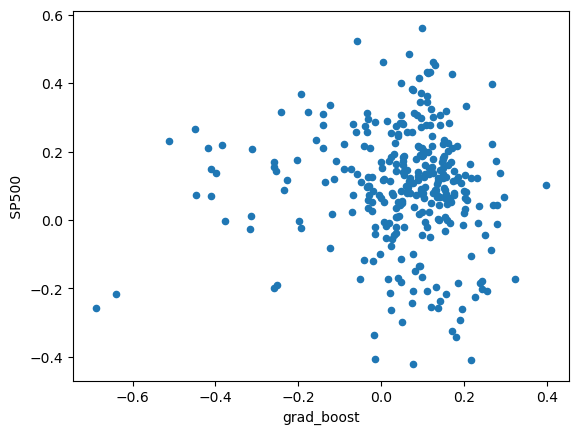

In [202]:
combined.plot(kind="scatter", y=' SP500 ', x='grad_boost')